In [1]:
import numpy as np
import bls_cpu as gbls
import transitPy5 as tpy5

In [2]:
gbls_inputs = gbls.gbls_inputs_class() # Initialize needed inputs

tic = 29991541
gbls_inputs.lcdir    = "/data2/TESS/ffisearch/cvzsearch_yr1/cvz1pt003/tlc"+str(tic)+"/"
gbls_inputs.filename = "tlc"+str(tic)+"_5.dn.dat"

# Read in photometry to photclass
phot = tpy5.readphot(gbls_inputs.lcdir + gbls_inputs.filename)

# Remove any offset from time stamps
gbls_inputs.zerotime = 1325.0

# 0 == no plots ; 1 = make a plot ; 2 make a plot and save it ; 3 just save the plot
gbls_inputs.plots = 1  #default is 1 

# Set frequency range by setting freqs1 and freqs2
# gbls_inputs.freq1 = 1/100 # scan from 100 days to 2 days
# gbls_inputs.freq2 = 1/2

# Set stellar parameters for optimum duration search
# gbls_inputs.Mstar = 1.0  #default is M = 1, R = 1
# gbls_inputs.Rstar = 1.0

# Set multipro = 0 for single thread jobs.  Default is 1.  
# gbls_inputs.multipro = 1

In [3]:
## Data processing 

# # Simple sigma cut on the data
# fstd = np.std(phot.flux)
# fstd_flag  = (np.abs(phot.flux - np.median(phot.flux)) < tpy5_inputs.fstd_cut*fstd) # & badcut
# phot.time  = phot.time[fstd_flag]
# phot.flux  = phot.flux[fstd_flag]
# phot.ferr  = phot.ferr[fstd_flag]
# phot.itime = phot.itime[fstd_flag]
# phot.tflag = phot.tflag[fstd_flag]
# phot.icut  = phot.icut[fstd_flag]

# # Detrender
# tpy5.run_polyfilter(phot, tpy5_inputs) -- will add flux_f to phot class

# # Outlier rejection
# tpy5.run_cutoutliers(phot, tpy5_inputs)

In [4]:
# If you used data processing, use phot.flux_f
#gbls_ans = gbls.bls(gbls_inputs, phot.time[phot.icut == 0], phot.flux[phot.icut == 0])

## Transit Modelling Section 

Note: in the utils folder run the following

`f2py -c tfit5.pyf transitmodel.f keplerian.f ttcor.f occultquad.f mandelagol.f rqsort.f transitdur.f -lgomp --f90flags='-fopenmp' --f77flags='-fopenmp'`  
  
`f2py -c fittransitmodel3.pyf precision.f90 fittermod.f90 fittransitmodel3.f90 getrhosig.f minpack.f transitmodel.f occultquad.f keplerian.f mandelagol.f ttcor.f -lgomp --f90flags='-fopenmp' --f77flags='-fopenmp'`  

and then copy (or move) the created `.so` files to the main code folder.

In [5]:
import transitfit5 as tf5 # will only load if the .so files are present (tfit5 and fittransitmodel.so

In [6]:
import importlib # Allow use to reload modules

In [7]:
importlib.reload(tf5)

<module 'transitfit5' from '/home/aroy/Documents/python/bls_cuda/transitfit5.py'>

In [8]:
print(tf5.transitmodel.__doc__)

Fortran Transit Model

    Usage: transitmodel(sol, time, itime=-1, ntt=0, tobs=0, omc=0, dtype=0, nintg=41)

    sol   - model parameters
    time  - array of time stamps
    itime - array of integration times (-1 defaults of 30-minutes for all measurements)
    ntt, tobs, omc - TTV parameters
    dtype = 0 (default is photometry)
    nintg = 41 (oversampling for integration times, can be safely reduced to 11)
    


In [9]:
#np.sqrt(gbls_ans.depth)

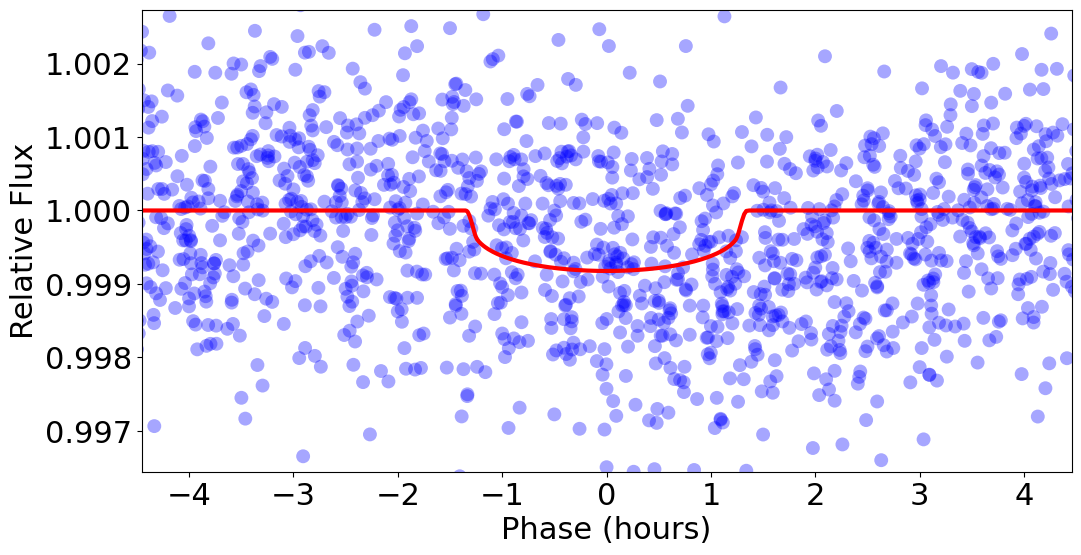

In [10]:
# A basic transit model

epo = 0.4498
bper = 2.483
rp_rs = 0.0263

sol = np.zeros(18) # single planet model has up-to 18-model parameters

sol[0]  = 0.8  # Mean stellar density (g/cm^3)
sol[1]  = 0.0  # Only used for non-linear limb-darkening
sol[2]  = 0.0  # Only used for non-linear limb-darkening
sol[3]  = 0.6  # q1 (limb-darkening)
sol[4]  = 0.4  # q2 (limb-darkening)
sol[5]  = 0.0  # dilution
sol[6]  = 0.0  # Velocity offset
sol[7]  = 0.0  # photometric zero point
sol[8]  = epo #gbls_ans.epo            # Center of transit time (days)
sol[9]  = bper #gbls_ans.bper           # Orbital Period (days)
sol[10] = 0.5                     # Impact parameter
sol[11] = rp_rs #np.sqrt(gbls_ans.depth) # Rp/R*
sol[12] = 0.0  # sqrt(e)cos(w)
sol[13] = 0.0  # sqrt(e)sin(w)
sol[14] = 0.0  # RV amplitude (m/s)
sol[15] = 0.0  # thermal eclipse depth (ppm)
sol[16] = 0.0  # Ellipsodial variations (ppm)
sol[17] = 0.0  # Albedo amplitude (ppm)
tf5.transitplot(phot.time - gbls_inputs.zerotime, phot.flux + 1, sol, itime = phot.itime)

In [11]:
tmodel = tf5.transitmodel(sol, phot.time, itime = phot.itime) #how to fetch a transit model

In [12]:
print(tf5.transitplot.__doc__)

Plot the transit model and data

    transitplot(time, flux, sol, nplanetplot=1, itime=-1, ntt=0, tobs=0, omc=0, dtype=0,nintg=41)
    


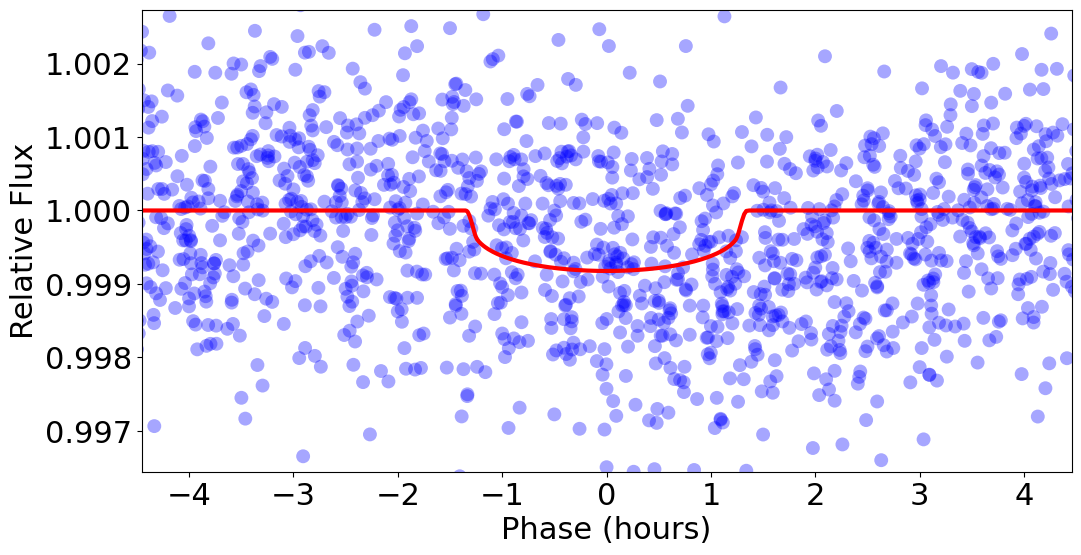

In [13]:
tf5.transitplot(phot.time - gbls_inputs.zerotime, phot.flux + 1, sol, itime = phot.itime)

In [14]:
import utils_python.transitmodel as transitm
import matplotlib.pyplot as plt
import importlib
import time

Numba time: 0.09422 s
Fortran time: 0.01202 s


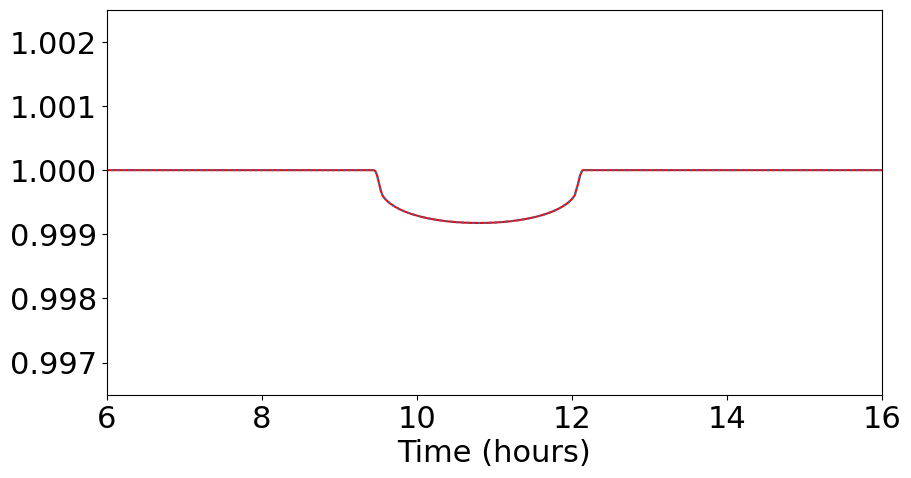

In [20]:
importlib.reload(transitm)

transitm.transitModel(sol, phot.time, phot.itime)

s = time.time()
A = transitm.transitModel(sol, phot.time, phot.itime)
print(f"Numba time: {time.time() - s:.5f} s")

s = time.time()
tmodel = tf5.transitmodel(sol, phot.time, itime = phot.itime)
print(f"Fortran time: {time.time() - s:.5f} s")

x = phot.time % bper
i_sort = np.argsort(x)

#plt.plot(phot.time % gbls_ans.bper, phot.flux + 1, "o", alpha=0.5, c="blue")
plt.figure(figsize=(10,5))
plt.plot(x[i_sort]*24, A[i_sort], c="red")
plt.plot(x[i_sort]*24, tmodel[i_sort], linestyle="dotted")
plt.xlabel("Time (hours)")
plt.xlim(6, 16)
plt.ylim(0.9965, 1.0025)
plt.show()